# Aerodynamic optimization for swashplateless VTOL MAV

### Import libraries

In [38]:
import aerosandbox as asb
import aerosandbox.numpy as np
import pyvista as pv
import matplotlib.pyplot as plt
import aerosandbox.tools.pretty_plots as p
from matplotlib.colors import LinearSegmentedColormap
from aerosandbox.tools.string_formatting import eng_string

### Generate NACA profiles to test

In [39]:
def generate_naca_profiles(min_camber, max_camber, min_camber_dist, max_camber_dist, min_thickness, max_thickness):
    naca_profiles = []

    for camber in range(min_camber, max_camber + 1):
        for camber_dist in range(min_camber_dist, max_camber_dist + 1, 2):
            if camber == 0 and camber_dist != 0:
                continue
            if camber != 0 and camber_dist == 0:
                continue
            for thickness in range(min_thickness, max_thickness + 1, 2):
                naca_code = f"naca{camber}{camber_dist}{thickness:02d}"
                naca_profiles.append(naca_code)

    return naca_profiles

min_camber = 0
max_camber = 4
min_camber_dist = 0
max_camber_dist = 6
min_thickness = 10
max_thickness = 16

naca_foils = generate_naca_profiles(min_camber, max_camber, min_camber_dist, max_camber_dist, min_thickness, max_thickness)
print(naca_foils)
print(len(naca_foils))

['naca0010', 'naca0012', 'naca0014', 'naca0016', 'naca1210', 'naca1212', 'naca1214', 'naca1216', 'naca1410', 'naca1412', 'naca1414', 'naca1416', 'naca1610', 'naca1612', 'naca1614', 'naca1616', 'naca2210', 'naca2212', 'naca2214', 'naca2216', 'naca2410', 'naca2412', 'naca2414', 'naca2416', 'naca2610', 'naca2612', 'naca2614', 'naca2616', 'naca3210', 'naca3212', 'naca3214', 'naca3216', 'naca3410', 'naca3412', 'naca3414', 'naca3416', 'naca3610', 'naca3612', 'naca3614', 'naca3616', 'naca4210', 'naca4212', 'naca4214', 'naca4216', 'naca4410', 'naca4412', 'naca4414', 'naca4416', 'naca4610', 'naca4612', 'naca4614', 'naca4616']
52


### Limitations for optimalization

In [56]:
# Initial guess for optimization variables
INIT_CHORD = 0.4
INIT_SPAN = 1.0
INIT_AIRSPEED = 10
INIT_ALPHA = 0

# Optimization LIMITS
MIN_CHORD = 0.25
MAX_CHORD = 0.5

MIN_SPAN = 0.7
MAX_SPAN = 1.2

MIN_AIRSPEED = 6
MAX_AIRSPEED = 10

MIN_ALPHA = 0
MAX_ALPHA = 12

MIN_WING_AREA = 0.35
MAX_WING_AREA = MAX_SPAN * MAX_CHORD

# Optimization CONSTRAINTS
NO_WING_WEIGHT = 0.97*9.81  # N, corresponding to the estimated weight of the airplane w/o the wing.
WING_DENSITY = 30 # kg/m^3, corresponding to the density of the wing material (xps foam).

### Find the best airfoil and planform

In [58]:
min_drag = []
max_cl_to_cd = [] 
optimal_airspeed = []
optimal_alpha = []
optimal_chord = []
optimal_span = []
optimal_lift = []

for profile in naca_foils:
    foil = asb.Airfoil(profile)

    opti = asb.Opti()

    chord_l = opti.variable(init_guess=INIT_CHORD, lower_bound=MIN_CHORD, upper_bound=MAX_CHORD, scale=0.5)
    span_l = opti.variable(init_guess=INIT_SPAN, lower_bound=MIN_SPAN, upper_bound=MAX_SPAN, scale=1)
    alpha_opt = opti.variable(init_guess=INIT_ALPHA, lower_bound=MIN_ALPHA, upper_bound=MAX_ALPHA, scale=3)
    v = opti.variable(init_guess=INIT_AIRSPEED, lower_bound=MIN_AIRSPEED, upper_bound=MAX_AIRSPEED, scale=10)

    wing = asb.Wing(
        symmetric=True,
        xsecs=[
            asb.WingXSec(
                xyz_le=[0, 0, 0],  # Coordinates of the XSec's leading edge, relative to the wing's leading edge.
                chord=chord_l,
                airfoil=foil,  # Airfoils are blended between a given XSec and the next one.
            ),
            asb.WingXSec(  # Tip
                xyz_le=[0, span_l/2, 0],
                chord=chord_l,
                airfoil=foil,
            )
        ]
    )
    
    airplane = asb.Airplane( # Make an airplane object containing only this wing.
        wings=[
            wing
        ]
    )
    
    op_point = asb.OperatingPoint(
        velocity=v,
        alpha=alpha_opt
    )

    vlm = asb.VortexLatticeMethod(
        airplane=airplane,
        op_point=op_point,
    )

    aero = vlm.run()
    
    opti.subject_to([
        aero["L"] == NO_WING_WEIGHT + airplane.wings[0].volume()*WING_DENSITY*9.81, # Compensate for added mass from wing,
        #airplane.wings[0].area() >= MIN_WING_AREA,
        #airplane.wings[0].area() <= MAX_WING_AREA,
    ])
    
    #opti.minimize(span_l*chord_l) # Minimize wing area
    #opti.minimize(alpha_opt) # Minimize alpha
    opti.maximize(aero["CL"]/aero["CD"]) # Maximize the lift to drag ratio
    #opti.minimize(aero["D"]) # Minimize drag
    
    sol = opti.solve(verbose=False)
    vlm = sol(vlm)
    opt_vel =  vlm.op_point.velocity

    best_alpha = sol.value(alpha_opt)
    best_chord = sol.value(chord_l)
    best_span = sol.value(span_l)
    opt_D = sol.value(aero["D"])
    aircraft_weight = sol.value(aero["L"])
    opt_cl_to_cd = sol.value(aero["CL"]/aero["CD"])
    min_drag.append(opt_D)
    max_cl_to_cd.append(opt_cl_to_cd)
    optimal_airspeed.append(opt_vel)
    optimal_alpha.append(best_alpha)
    optimal_chord.append(best_chord)
    optimal_span.append(best_span)
    optimal_lift.append(aircraft_weight)
    print(f"{profile} is best with chord: {best_chord:.2f} and span: {best_span:.2f}, operating at alpha: {best_alpha:.2f} deg, airspeed: {INIT_AIRSPEED:.1f} m/s, optimal drag: {opt_D:.6f} N, optimal cl/cd: {opt_cl_to_cd:.6f}, Weight: {aircraft_weight:.2f} N")


naca0010 is best with chord: 0.25 and span: 1.20, operating at alpha: 8.60 deg, airspeed: 10.0 m/s, optimal drag: 0.420421 N, optimal cl/cd: 26.230401, Weight: 11.03 N
naca0012 is best with chord: 0.25 and span: 1.20, operating at alpha: 8.84 deg, airspeed: 10.0 m/s, optimal drag: 0.443798 N, optimal cl/cd: 25.530149, Weight: 11.33 N
naca0014 is best with chord: 0.25 and span: 1.20, operating at alpha: 9.08 deg, airspeed: 10.0 m/s, optimal drag: 0.467807 N, optimal cl/cd: 24.866318, Weight: 11.63 N
naca0016 is best with chord: 0.25 and span: 1.20, operating at alpha: 9.32 deg, airspeed: 10.0 m/s, optimal drag: 0.492452 N, optimal cl/cd: 24.236039, Weight: 11.94 N
naca1210 is best with chord: 0.25 and span: 1.20, operating at alpha: 7.72 deg, airspeed: 10.0 m/s, optimal drag: 0.420370 N, optimal cl/cd: 26.234634, Weight: 11.03 N
naca1212 is best with chord: 0.25 and span: 1.20, operating at alpha: 7.95 deg, airspeed: 10.0 m/s, optimal drag: 0.443814 N, optimal cl/cd: 25.530459, Weight: 

In [69]:
# Find the minimum value and its index
sorted_results = sorted(max_cl_to_cd, reverse=True)
print("Top 10 best airfoils for maximum lift-to-drag:")
for result in sorted_results[:10]:
    index = max_cl_to_cd.index(result)
    print(f"{sorted_results.index(result)+1} : {naca_foils[index]} at L: {optimal_lift[index]:.5f}, D: {min_drag[index]:.5f} N, cl/cd: {max_cl_to_cd[index]:.5f}, alpha: {optimal_alpha[index]:.2f} deg, chord: {optimal_chord[index]:.2f}, span: {optimal_span[index]:.2f}")
max_value = max(max_cl_to_cd)
min_index = max_cl_to_cd.index(max_value)
best_profile = naca_foils[min_index]

print(f"Maximum lift to drag ratio: {max_value}")
print(f"Index of max lift to drag ratio: {min_index}")
print(f"Best profile for conditions: {best_profile}")

Top 10 best airfoils for maximum lift-to-drag:
1 : naca1210 at L: 11.02825, D: 0.42037 N, cl/cd: 26.23463, alpha: 7.72 deg, chord: 0.25, span: 1.20
2 : naca2210 at L: 11.02964, D: 0.42048 N, cl/cd: 26.23092, alpha: 6.82 deg, chord: 0.25, span: 1.20
3 : naca0010 at L: 11.02781, D: 0.42042 N, cl/cd: 26.23040, alpha: 8.60 deg, chord: 0.25, span: 1.20
4 : naca1410 at L: 11.02812, D: 0.42050 N, cl/cd: 26.22617, alpha: 7.59 deg, chord: 0.25, span: 1.20
5 : naca2410 at L: 11.02911, D: 0.42060 N, cl/cd: 26.22241, alpha: 6.57 deg, chord: 0.25, span: 1.20
6 : naca1610 at L: 11.02806, D: 0.42087 N, cl/cd: 26.20314, alpha: 7.36 deg, chord: 0.25, span: 1.20
7 : naca3410 at L: 11.03077, D: 0.42107 N, cl/cd: 26.19695, alpha: 5.55 deg, chord: 0.25, span: 1.20
8 : naca3210 at L: 11.03194, D: 0.42127 N, cl/cd: 26.18703, alpha: 5.93 deg, chord: 0.25, span: 1.20
9 : naca2610 at L: 11.02888, D: 0.42127 N, cl/cd: 26.17994, alpha: 6.11 deg, chord: 0.25, span: 1.20
10 : naca3610 at L: 11.03024, D: 0.42203 N, 

In [77]:
# Create aeroplane from the found best parameters
rank = 2 # rank of the airfoil to analyze
index_to_eval = max_cl_to_cd.index(sorted_results[rank-1])
print(index_to_eval)

print(f"Analyzing airfoil {naca_foils[index_to_eval]} at rank {rank} with cl/cd: {max_cl_to_cd[index_to_eval]}")

wing = asb.Wing(
    symmetric=True,
    xsecs=[
        asb.WingXSec(
            xyz_le=[0, 0, 0],  # Coordinates of the XSec's leading edge, relative to the wing's leading edge.
            chord=optimal_chord[index_to_eval],
            airfoil=asb.Airfoil(naca_foils[index_to_eval]),  # Airfoils are blended between a given XSec and the next one.
        ),
        asb.WingXSec(  # Tip
            xyz_le=[0, optimal_span[index_to_eval]/2, 0],
            chord=optimal_chord[index_to_eval],
            airfoil=asb.Airfoil(naca_foils[index_to_eval]),
        )
    ]
)
best_airplane = asb.Airplane( # Make an airplane object containing only this wing.
    wings=[
        wing
    ]
)

optimal_op_point = asb.OperatingPoint(
    velocity=optimal_airspeed[index_to_eval],
    alpha=optimal_alpha[index_to_eval]
)

opt_vlm = asb.VortexLatticeMethod(
    airplane=best_airplane,
    op_point=optimal_op_point,
    align_trailing_vortices_with_wind=False,
)

aero = opt_vlm.run()
for k, v in aero.items():
    print(f"{k.rjust(4)} : {v}")

16
Analyzing airfoil naca2210 at rank 2 with cl/cd: 26.230923341734176
 F_g : [-0.89317294  0.         11.00145699]
 F_b : (0.8931729425993411, 0.0, -11.001456985337859)
 F_w : (-0.4204824248699519, 0.0, -11.029642253310222)
 M_g : [-1.32199481e-15 -8.28165423e-01 -4.95463452e-17]
 M_b : (1.3219948139658877e-15, -0.8281654228632291, 4.9546345216693044e-17)
 M_w : (1.318515330465401e-15, -0.8281654228632291, -1.0790019371969711e-16)
   L : 11.029642253310222
   D : 0.4204824248699519
   Y : 0.0
 l_b : 1.3219948139658877e-15
 m_b : -0.8281654228632291
 n_b : 4.9546345216693044e-17
  CL : 0.600253047167158
  CD : 0.022883412808123945
  CY : 0.0
  Cl : 5.995445343871814e-17
  Cm : -0.1802810343469557
  Cn : 2.2470012862164892e-18


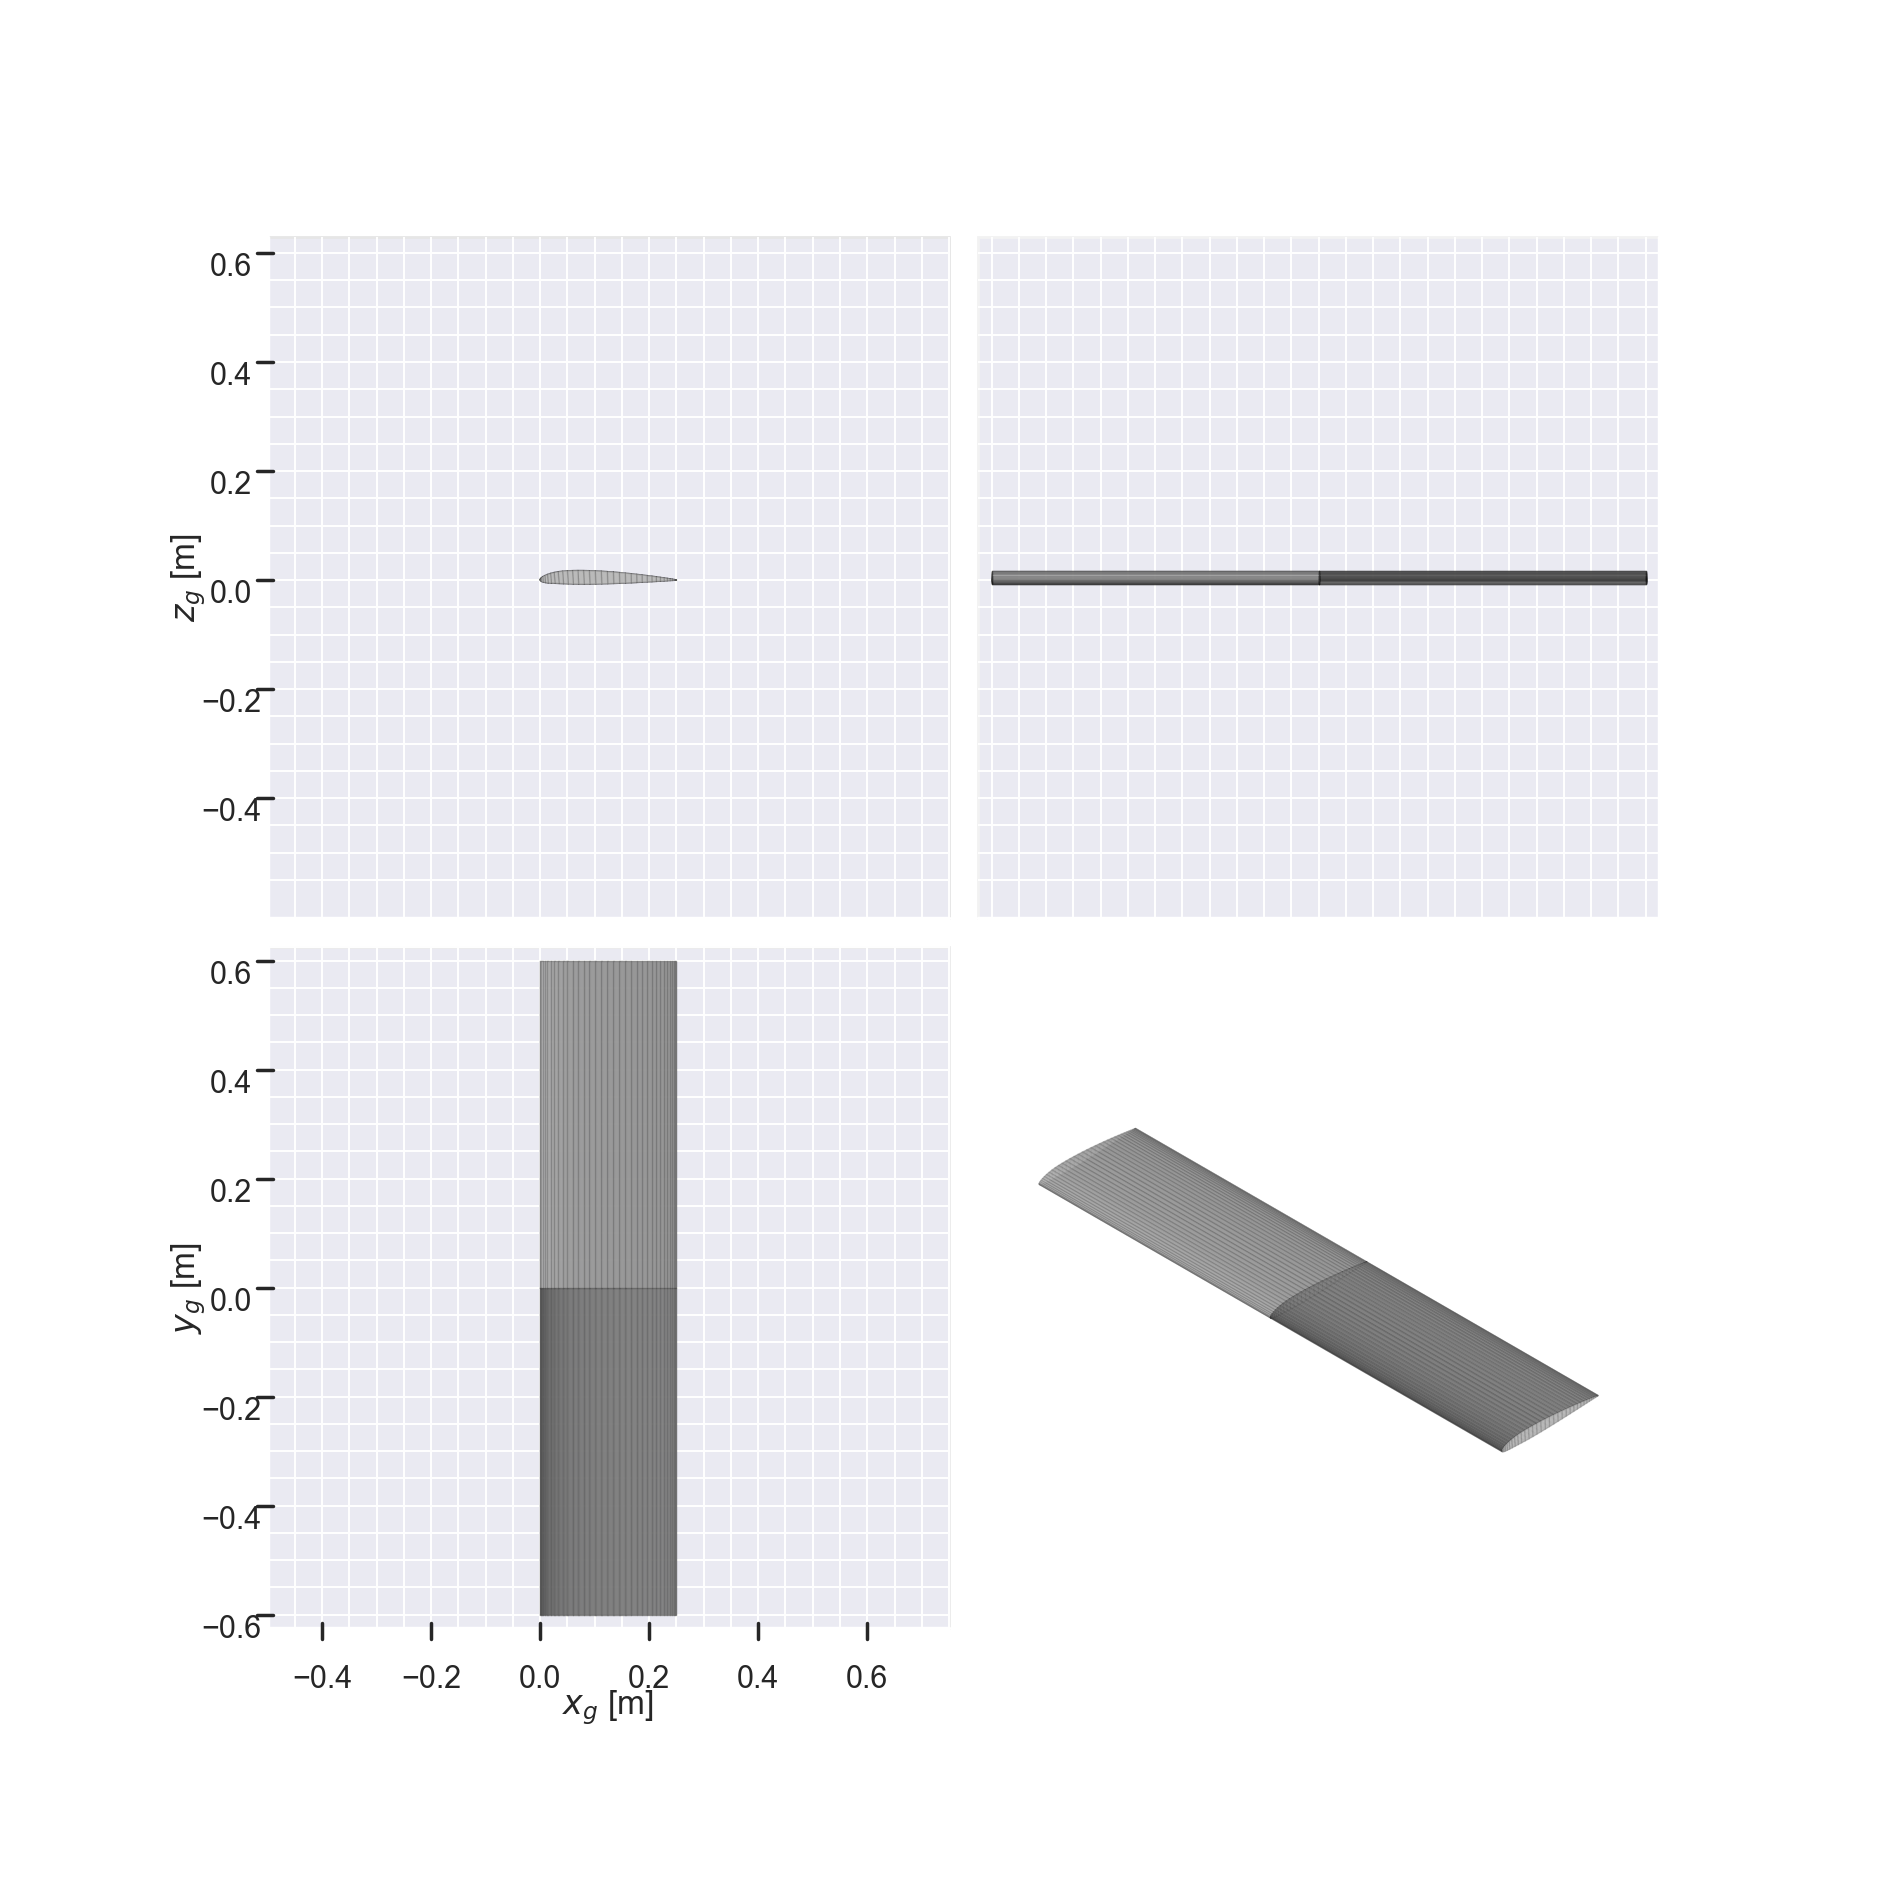

In [78]:
best_airplane.draw_three_view()

### plot results for best performing airfoil

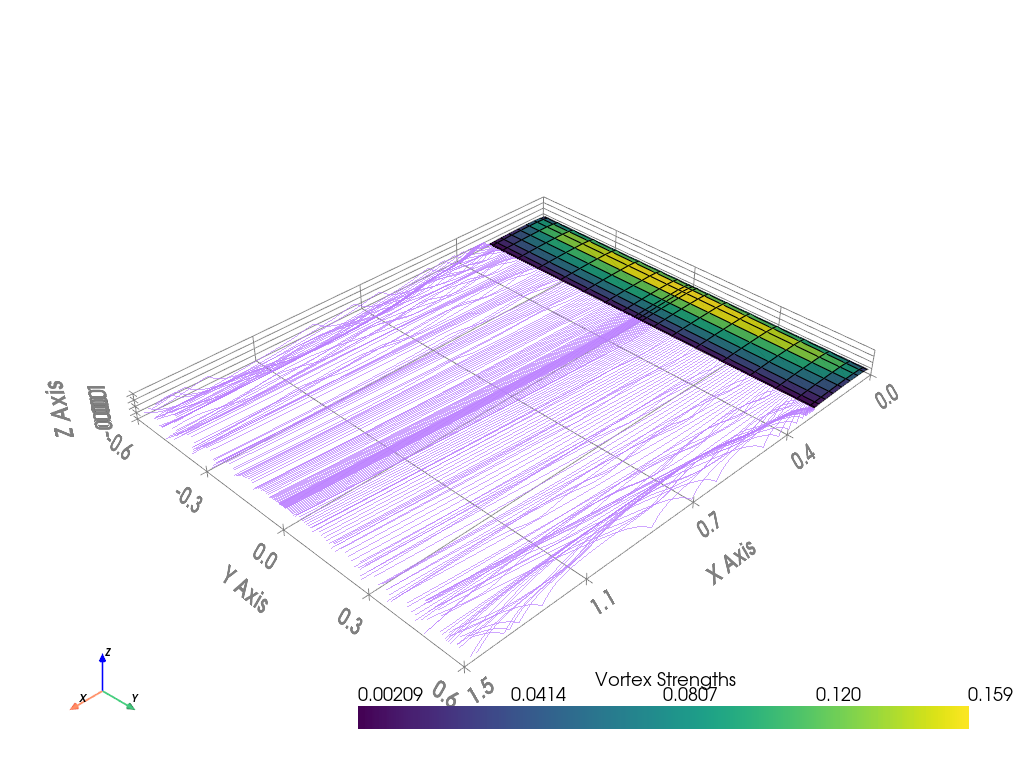

In [79]:
opt_vlm.draw(show_kwargs=dict(jupyter_backend="static"))

### Plot polars

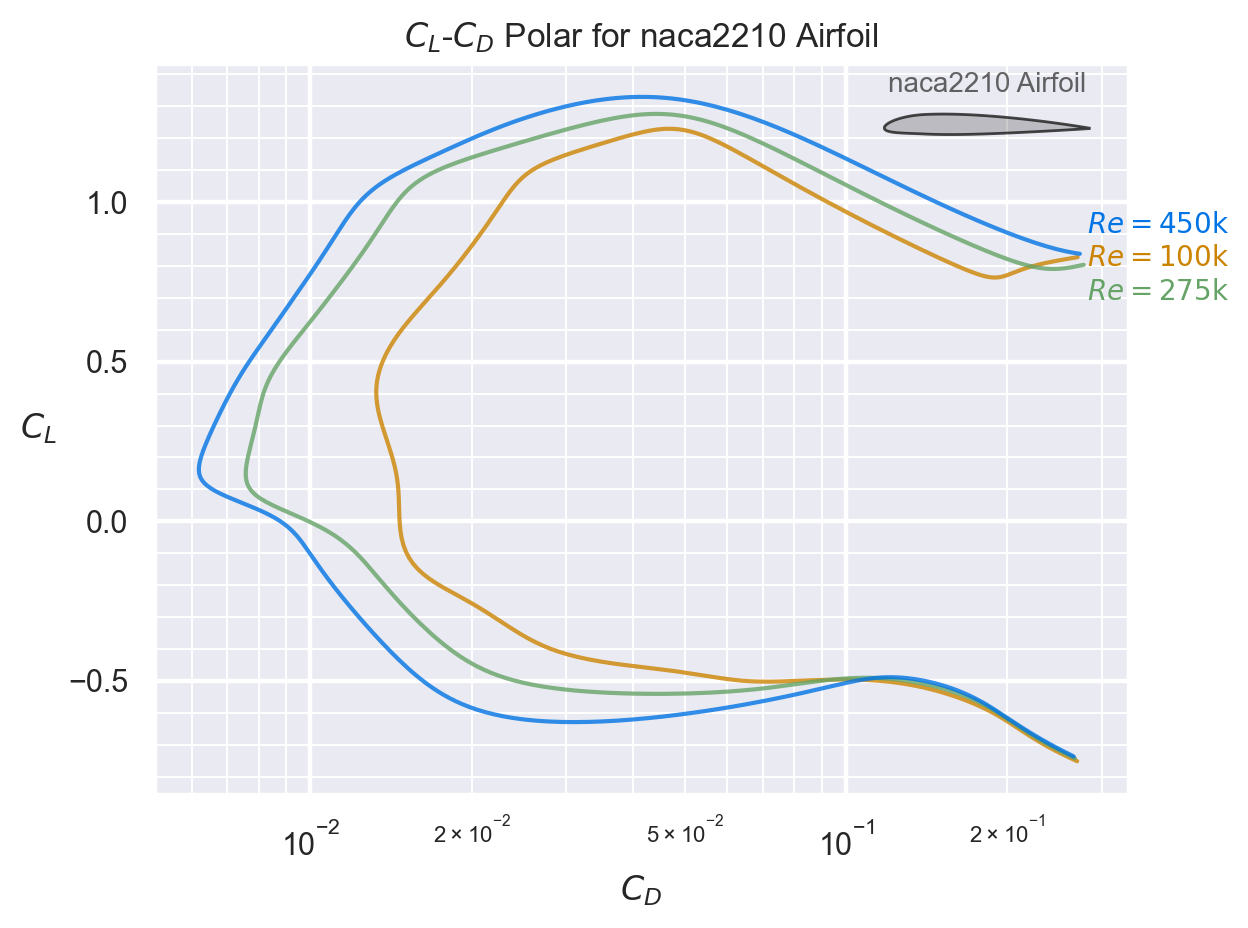

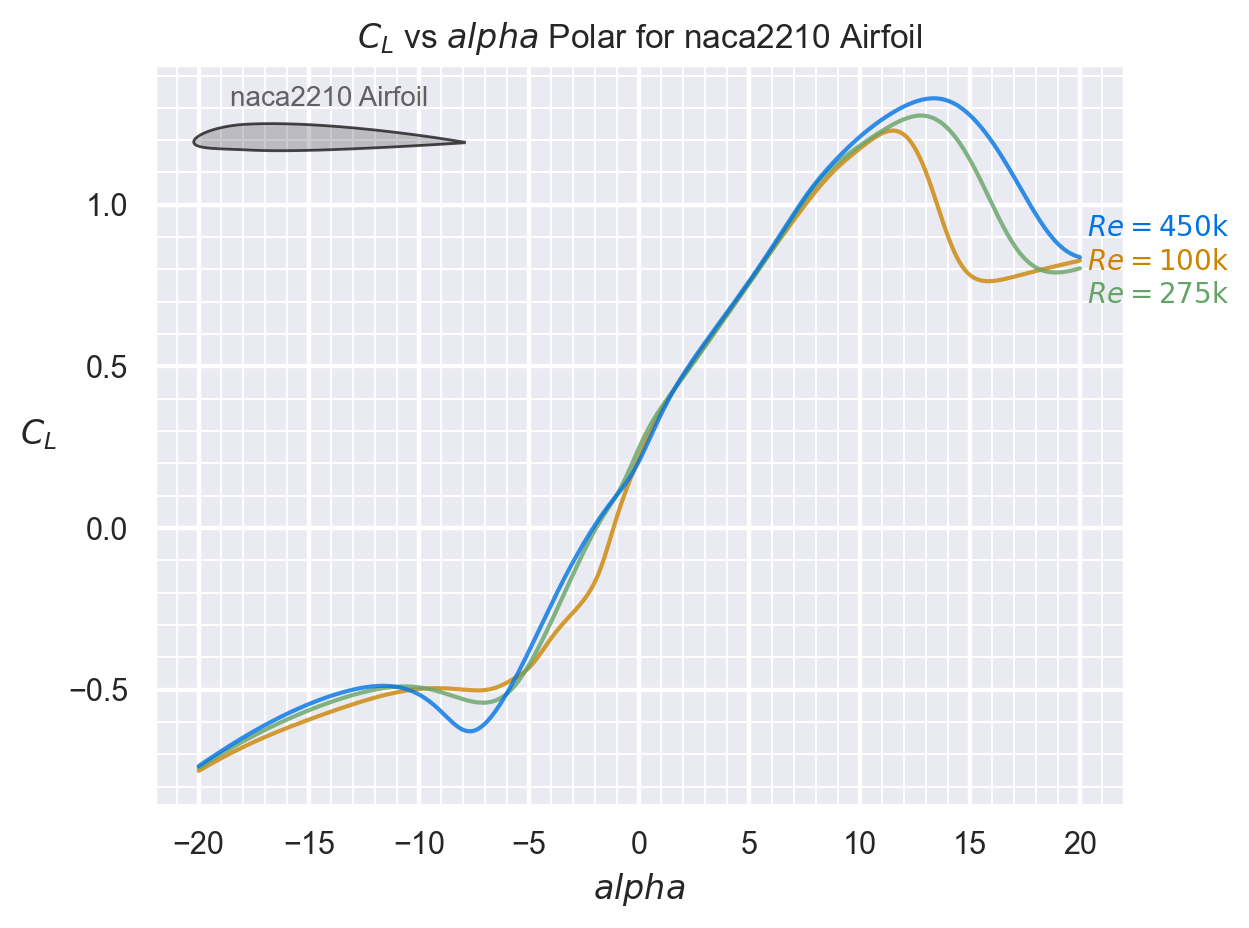

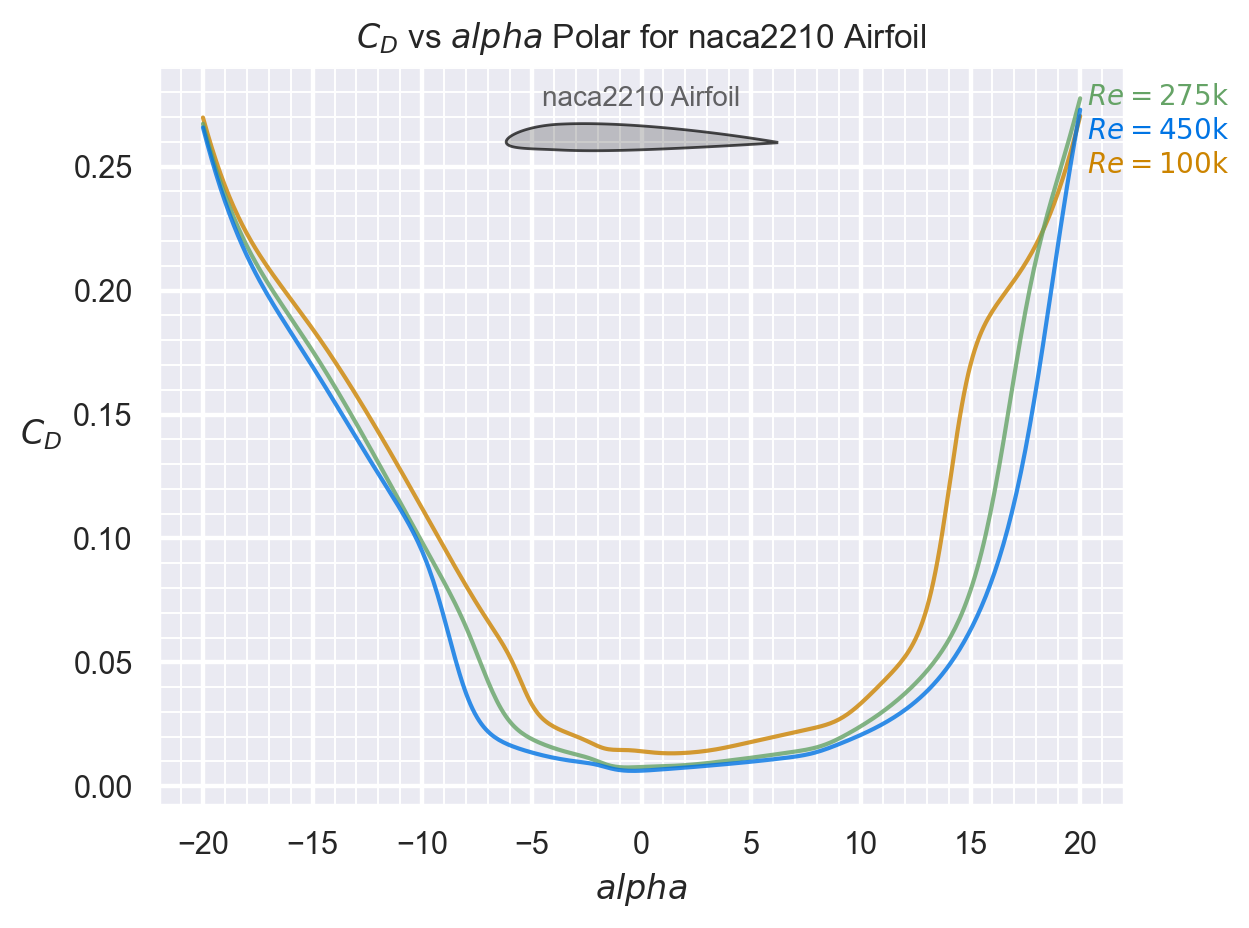

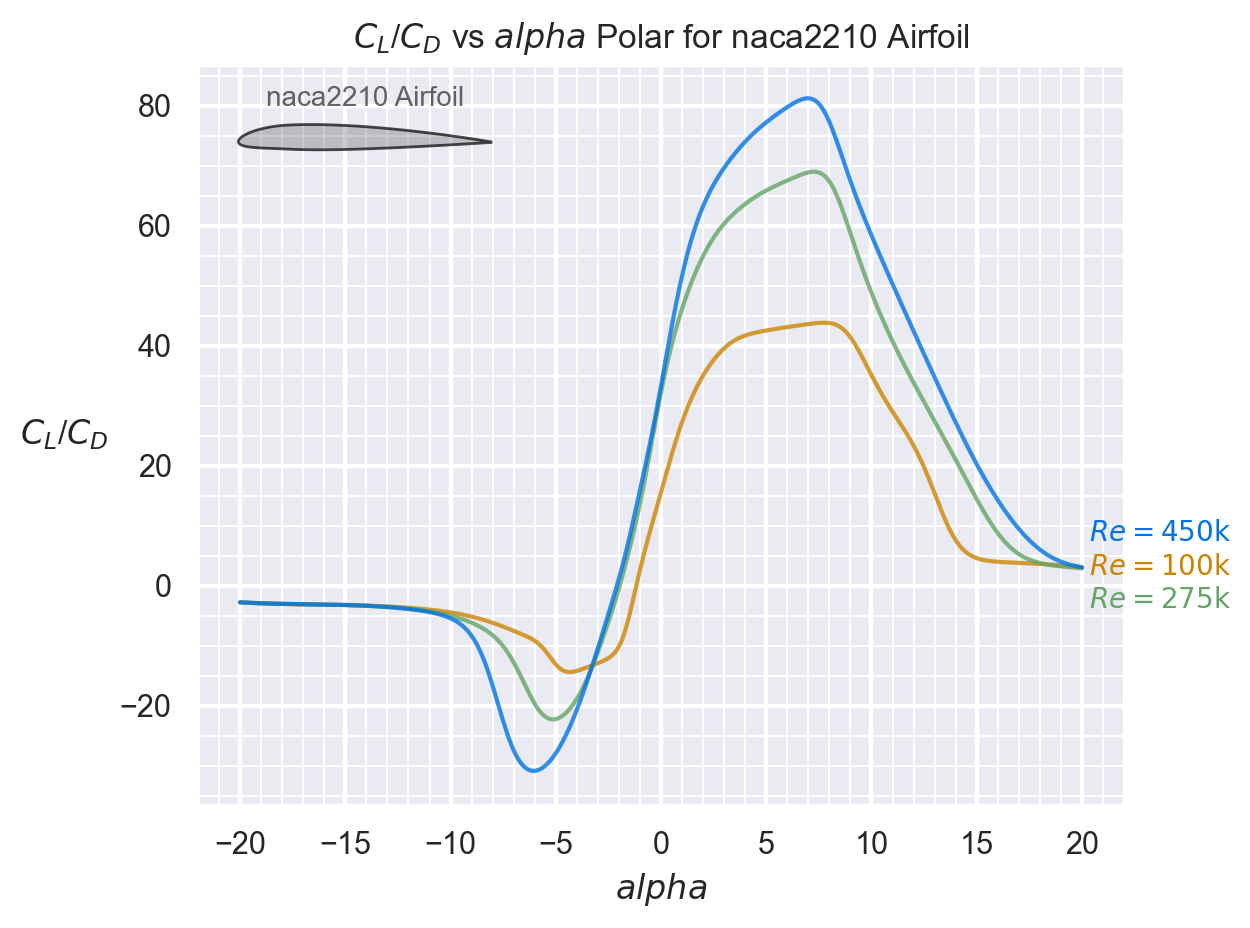

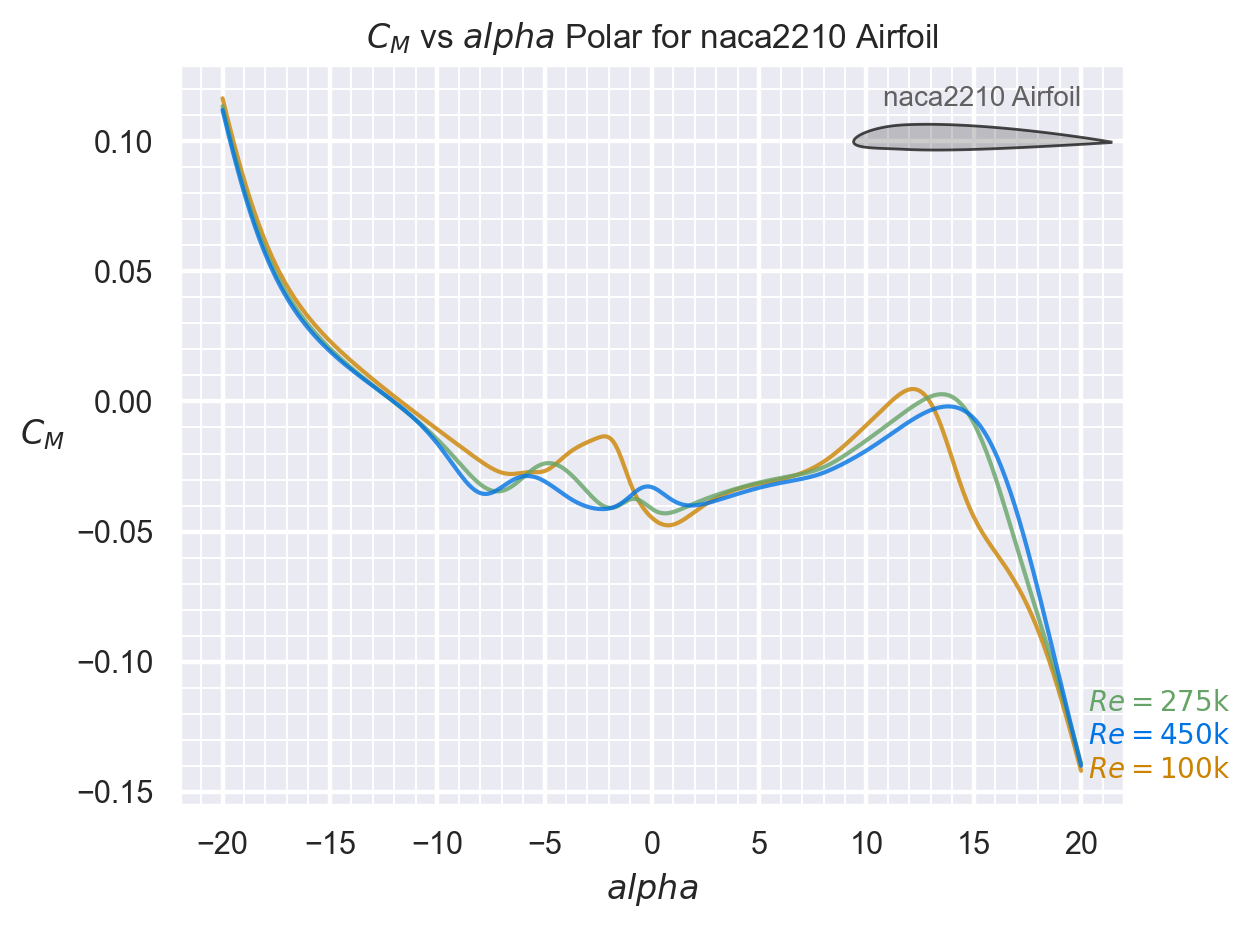

In [89]:
alphas = np.linspace(-20, 20, 401)  # degrees
re = np.linspace(1e5, 4.5e5, 3) #Range of Reynolds numbers to plot
Alpha, Re = np.meshgrid(alphas, re)

af = asb.Airfoil(naca_foils[index_to_eval])

aero_flattened = af.get_aero_from_neuralfoil(
    alpha=Alpha.flatten(),
    Re=Re.flatten(),
    mach=0,
    model_size="xxxlarge",
)
Aero = {
    key: value.reshape(Alpha.shape)
    for key, value in aero_flattened.items()
}


    colors = LinearSegmentedColormap.from_list(
        "custom_cmap",
        colors=[
            p.adjust_lightness(c, 0.8) for c in
            ["orange", "darkseagreen", "dodgerblue"]
        ]
    )(np.linspace(0, 1, len(re)))

text_height_offset = 0.05

##### Plot CD vs CL #####
fig, ax = plt.subplots()
y_endpoints = []
y_max = []
y_min = []
for i in range(len(re)):
    line, = ax.plot(
        Aero["CD"][i, :],
        Aero["CL"][i, :],
        color=colors[i], alpha=0.8,
    )
    y_max.append(np.max(line.get_ydata()))
    y_min.append(np.min(line.get_ydata()))
    y_endpoints.append(line.get_ydata()[-1])
sorted_endpoints, y_coordinates = spread_y_labels(y_endpoints, spacing=text_height_offset, ymin=np.min(y_min), ymax=np.max(y_max))

for i in range(len(re)):
    y_coord = y_coordinates[sorted_endpoints.index(y_endpoints[i])]
    plt.annotate(
        f" $Re = \\mathrm{{{eng_string(re[i])}}}$",
        xy=(line.get_xdata()[-1], y_coord),
        color=colors[i],
        ha="left", va="center", fontsize=10
    )

afax = ax.inset_axes([0.74, 0.802, 0.23, 0.23])
afax.fill(
    af.x(), af.y(),
    facecolor=(0, 0, 0, 0.2), linewidth=1, edgecolor=(0, 0, 0, 0.7)
)
afax.annotate(
    text=f"{af.name} Airfoil\n",
    xy=(0.5, 0),
    ha="center", va="bottom", fontsize=10,
    alpha=0.7
)
afax.axis('off')
afax.axis('equal')

plt.xscale('log')
p.show_plot(
    title=f"$C_L$-$C_D$ Polar for {af.name} Airfoil",
    xlabel="$C_D$",
    ylabel="$C_L$",
)

##### Plot CL vs alpha #####
fig, ax = plt.subplots()
y_endpoints = []
y_max = []
y_min = []
for i in range(len(re)):
    line, = ax.plot(
        Alpha[i, :],
        Aero["CL"][i, :],
        color=colors[i], alpha=0.8,
    )
    y_max.append(np.max(line.get_ydata()))
    y_min.append(np.min(line.get_ydata()))
    y_endpoints.append(line.get_ydata()[-1])
y_max = np.max(y_max)
y_min = np.min(y_min)
sorted_endpoints, y_coordinates = spread_y_labels(y_endpoints, spacing=text_height_offset, ymin=np.min(y_min), ymax=np.max(y_max))

for i in range(len(re)):
    y_coord = y_coordinates[sorted_endpoints.index(y_endpoints[i])]
    plt.annotate(
        f" $Re = \\mathrm{{{eng_string(re[i])}}}$",
        xy=(line.get_xdata()[-1], y_coord),
        color=colors[i],
        ha="left", va="center", fontsize=10
    )

afax = ax.inset_axes([0.03, 0.752, 0.3, 0.3])
afax.fill(
    af.x(), af.y(),
    facecolor=(0, 0, 0, 0.2), linewidth=1, edgecolor=(0, 0, 0, 0.7)
)
afax.annotate(
    text=f"{af.name} Airfoil\n",
    xy=(0.5, 0),
    ha="center", va="bottom", fontsize=10,
    alpha=0.7
)
afax.axis('off')
afax.axis('equal')

p.show_plot(
    title=f"$C_L$ vs $alpha$ Polar for {af.name} Airfoil",
    xlabel="$alpha$",
    ylabel="$C_L$",
)

##### Plot CD vs alpha #####
fig, ax = plt.subplots()
y_endpoints = []
y_max = []
y_min = []
for i in range(len(re)):
    line, = ax.plot(
        Alpha[i, :],
        Aero["CD"][i, :],
        color=colors[i], alpha=0.8,
    )
    y_max.append(np.max(line.get_ydata()))
    y_min.append(np.min(line.get_ydata()))
    y_endpoints.append(line.get_ydata()[-1])
y_max = np.max(y_max)
y_min = np.min(y_min)
sorted_endpoints, y_coordinates = spread_y_labels(y_endpoints, spacing=text_height_offset, ymin=np.min(y_min), ymax=np.max(y_max))

for i in range(len(re)):
    y_coord = y_coordinates[sorted_endpoints.index(y_endpoints[i])]
    plt.annotate(
        f" $Re = \\mathrm{{{eng_string(re[i])}}}$",
        xy=(line.get_xdata()[-1], y_coord),
        color=colors[i],
        ha="left", va="center", fontsize=10
    )

afax = ax.inset_axes([0.35, 0.752, 0.3, 0.3])
afax.fill(
    af.x(), af.y(),
    facecolor=(0, 0, 0, 0.2), linewidth=1, edgecolor=(0, 0, 0, 0.7)
)
afax.annotate(
    text=f"{af.name} Airfoil\n",
    xy=(0.5, 0),
    ha="center", va="bottom", fontsize=10,
    alpha=0.7
)
afax.axis('off')
afax.axis('equal')

p.show_plot(
    title=f"$C_D$ vs $alpha$ Polar for {af.name} Airfoil",
    xlabel="$alpha$",
    ylabel="$C_D$",
)

##### Plot CL/CD vs alpha #####
fig, ax = plt.subplots()
y_endpoints = []
y_max = []
y_min = []
for i in range(len(re)):
    line, = ax.plot(
        Alpha[i, :],
        Aero["CL"][i, :]/Aero["CD"][i, :],
        color=colors[i], alpha=0.8,
    )
    y_max.append(np.max(line.get_ydata()))
    y_min.append(np.min(line.get_ydata()))
    y_endpoints.append(line.get_ydata()[-1])
y_max = np.max(y_max)
y_min = np.min(y_min)
sorted_endpoints, y_coordinates = spread_y_labels(y_endpoints, spacing=text_height_offset, ymin=np.min(y_min), ymax=np.max(y_max))

for i in range(len(re)):
    y_coord = y_coordinates[sorted_endpoints.index(y_endpoints[i])]
    plt.annotate(
        f" $Re = \\mathrm{{{eng_string(re[i])}}}$",
        xy=(line.get_xdata()[-1], y_coord),
        color=colors[i],
        ha="left", va="center", fontsize=10
    )

afax = ax.inset_axes([0.03, 0.752, 0.3, 0.3])
afax.fill(
    af.x(), af.y(),
    facecolor=(0, 0, 0, 0.2), linewidth=1, edgecolor=(0, 0, 0, 0.7)
)
afax.annotate(
    text=f"{af.name} Airfoil\n",
    xy=(0.5, 0),
    ha="center", va="bottom", fontsize=10,
    alpha=0.7
)
afax.axis('off')
afax.axis('equal')

p.show_plot(
    title=f"$C_L$/$C_D$ vs $alpha$ Polar for {af.name} Airfoil",
    xlabel="$alpha$",
    ylabel="$C_L$/$C_D$",
)

##### Plot CM vs alpha #####
fig, ax = plt.subplots()
y_endpoints = []
y_max = []
y_min = []
for i in range(len(re)):
    line, = ax.plot(
        Alpha[i, :],
        Aero["CM"][i, :],
        color=colors[i], alpha=0.8,
    )
    y_max.append(np.max(line.get_ydata()))
    y_min.append(np.min(line.get_ydata()))
    y_endpoints.append(line.get_ydata()[-1])
y_max = np.max(y_max)
y_min = np.min(y_min)
sorted_endpoints, y_coordinates = spread_y_labels(y_endpoints, spacing=text_height_offset, ymin=np.min(y_min), ymax=np.max(y_max))

for i in range(len(re)):
    y_coord = y_coordinates[sorted_endpoints.index(y_endpoints[i])]
    plt.annotate(
        f" $Re = \\mathrm{{{eng_string(re[i])}}}$",
        xy=(line.get_xdata()[-1], y_coord),
        color=colors[i],
        ha="left", va="center", fontsize=10
    )

afax = ax.inset_axes([0.70, 0.752, 0.3, 0.3])
afax.fill(
    af.x(), af.y(),
    facecolor=(0, 0, 0, 0.2), linewidth=1, edgecolor=(0, 0, 0, 0.7)
)
afax.annotate(
    text=f"{af.name} Airfoil\n",
    xy=(0.5, 0),
    ha="center", va="bottom", fontsize=10,
    alpha=0.7
)
afax.axis('off')
afax.axis('equal')

p.show_plot(
    title=f"$C_M$ vs $alpha$ Polar for {af.name} Airfoil",
    xlabel="$alpha$",
    ylabel="$C_M$",
)


### Compare the 10 best airfoils at fixed Reynplds number

In [83]:
def spread_y_labels(y_endpoints, spacing=0.08, ymin = -1, ymax = 1):
    """
    Spreads out the labels meant to be placed at the endpoint of a curve.
    :param spacing: Spacing between y-axis labels, in axis units.
    :return: list of y-axis coordinates for the labels.
    """
    scaling = ymax - ymin
    sorted_y_endpoints = sorted(y_endpoints)
    num_labels = len(sorted_y_endpoints)
    y_midpoint = (sorted_y_endpoints[0] + sorted_y_endpoints[-1]) / 2
    spread_in_y = spacing*scaling * (num_labels - 1)
    y_start = y_midpoint - spread_in_y / 2
    if y_start < ymin:
        y_start = ymin
    if y_start + spread_in_y > ymax:
        y_start = ymax - spread_in_y
    spaced_coords = [y_start + i * spacing*scaling for i in range(num_labels)]
    return sorted_y_endpoints, spaced_coords

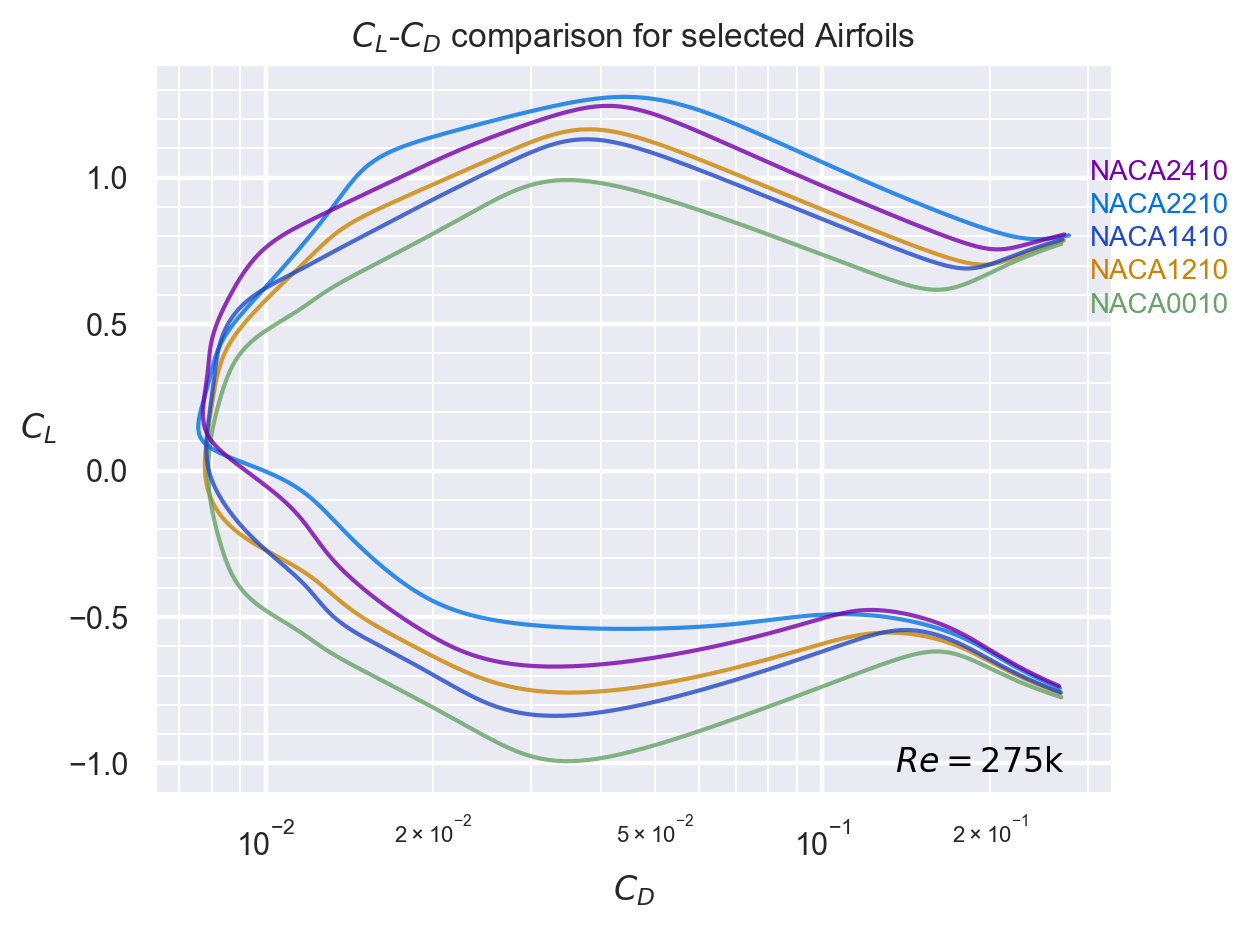

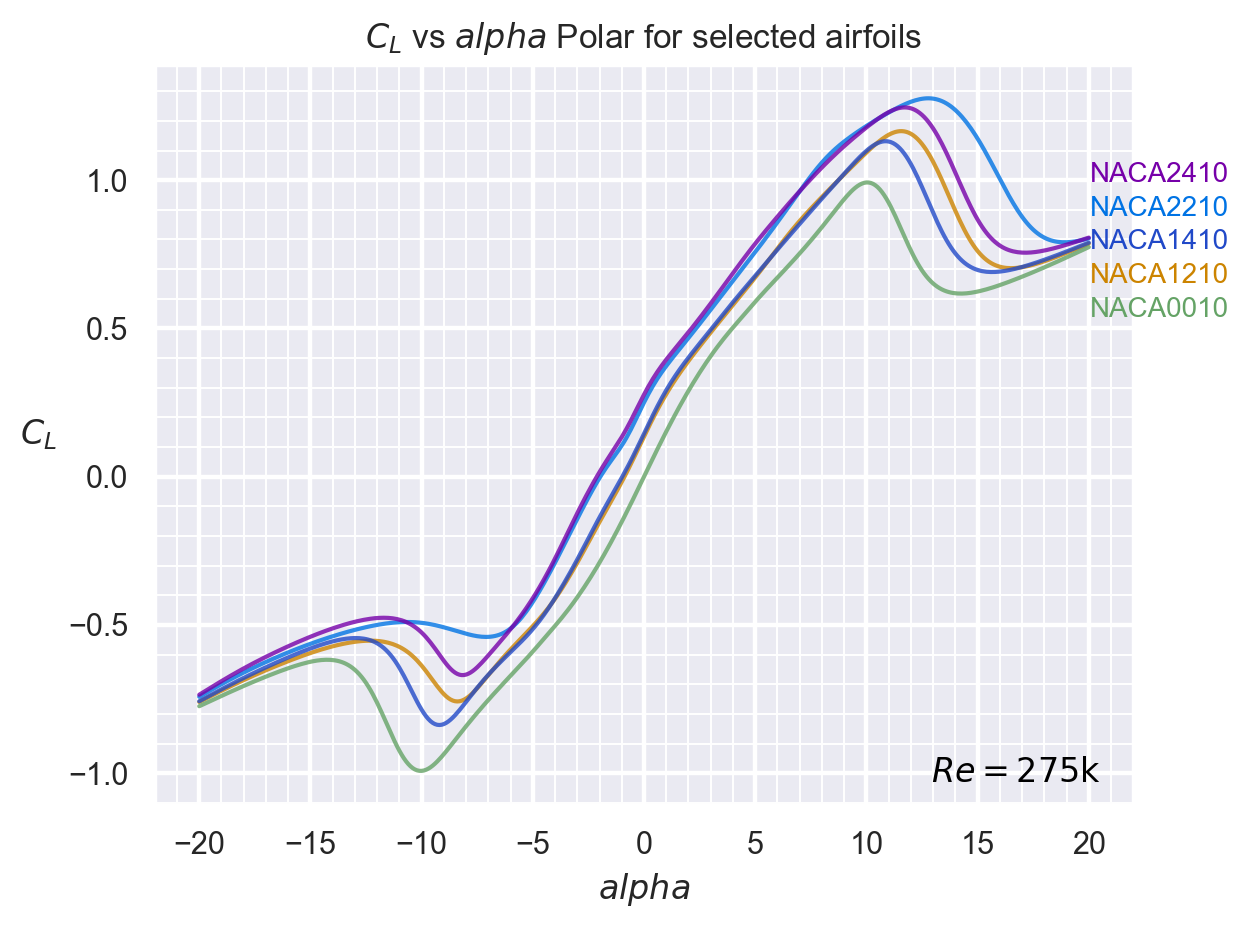

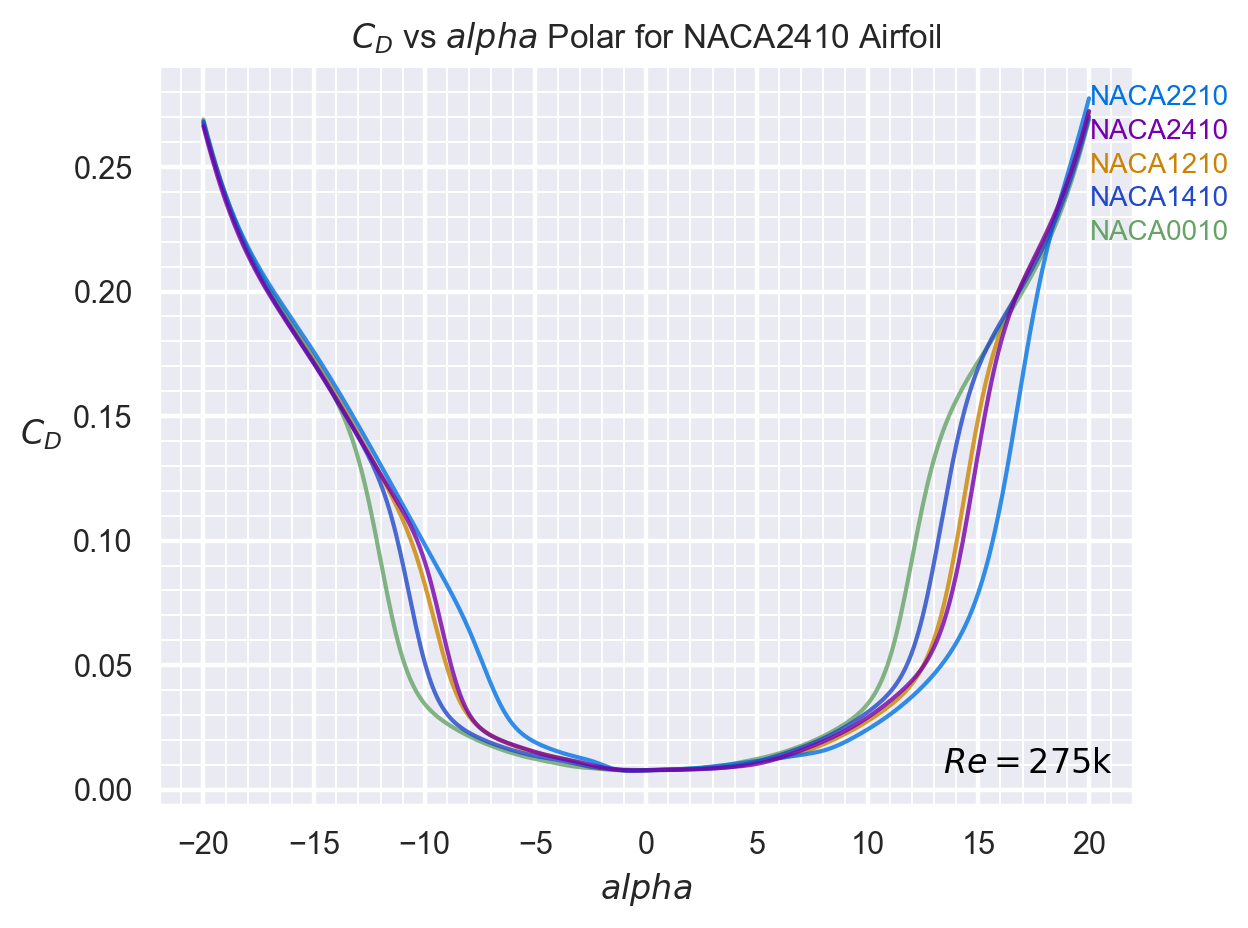

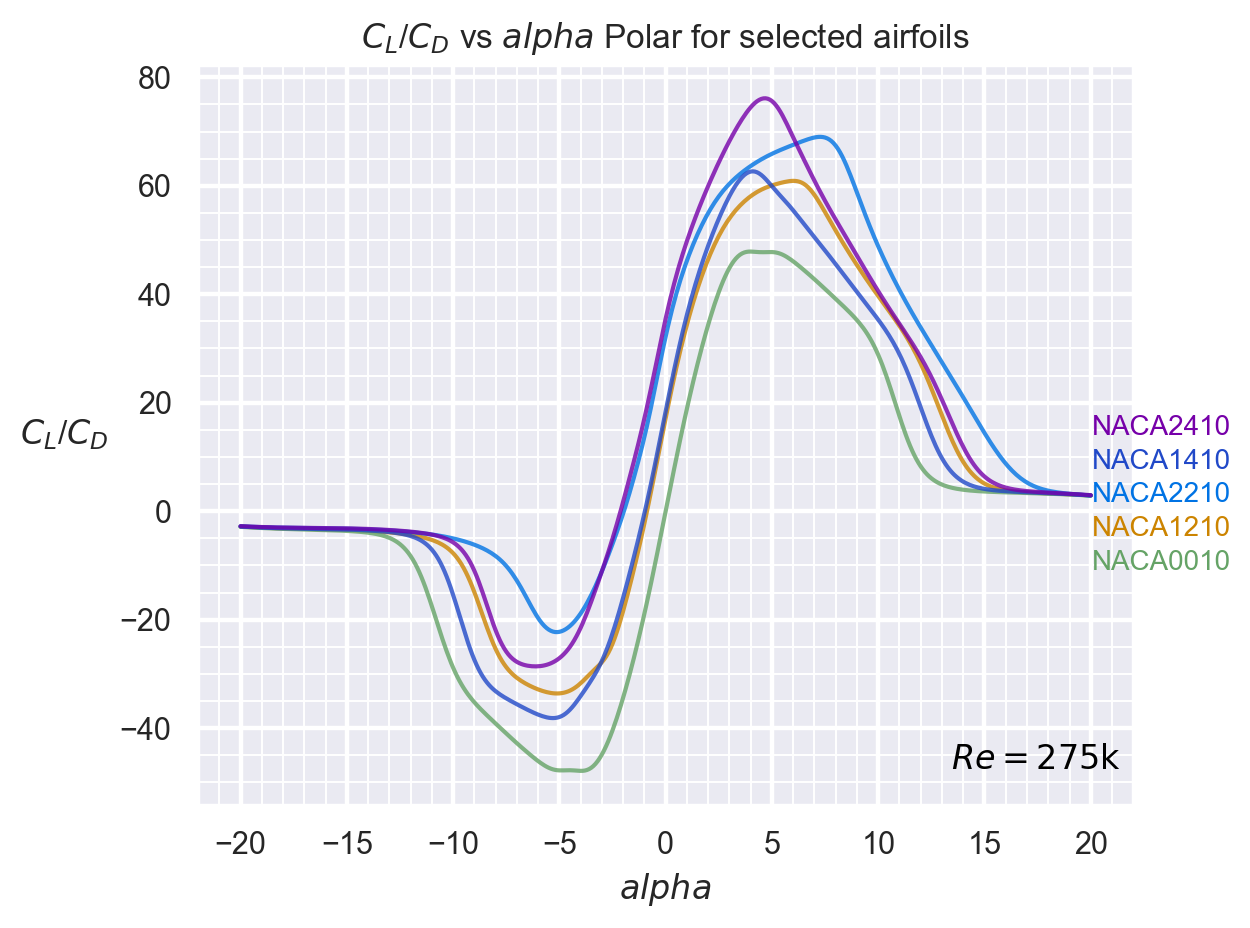

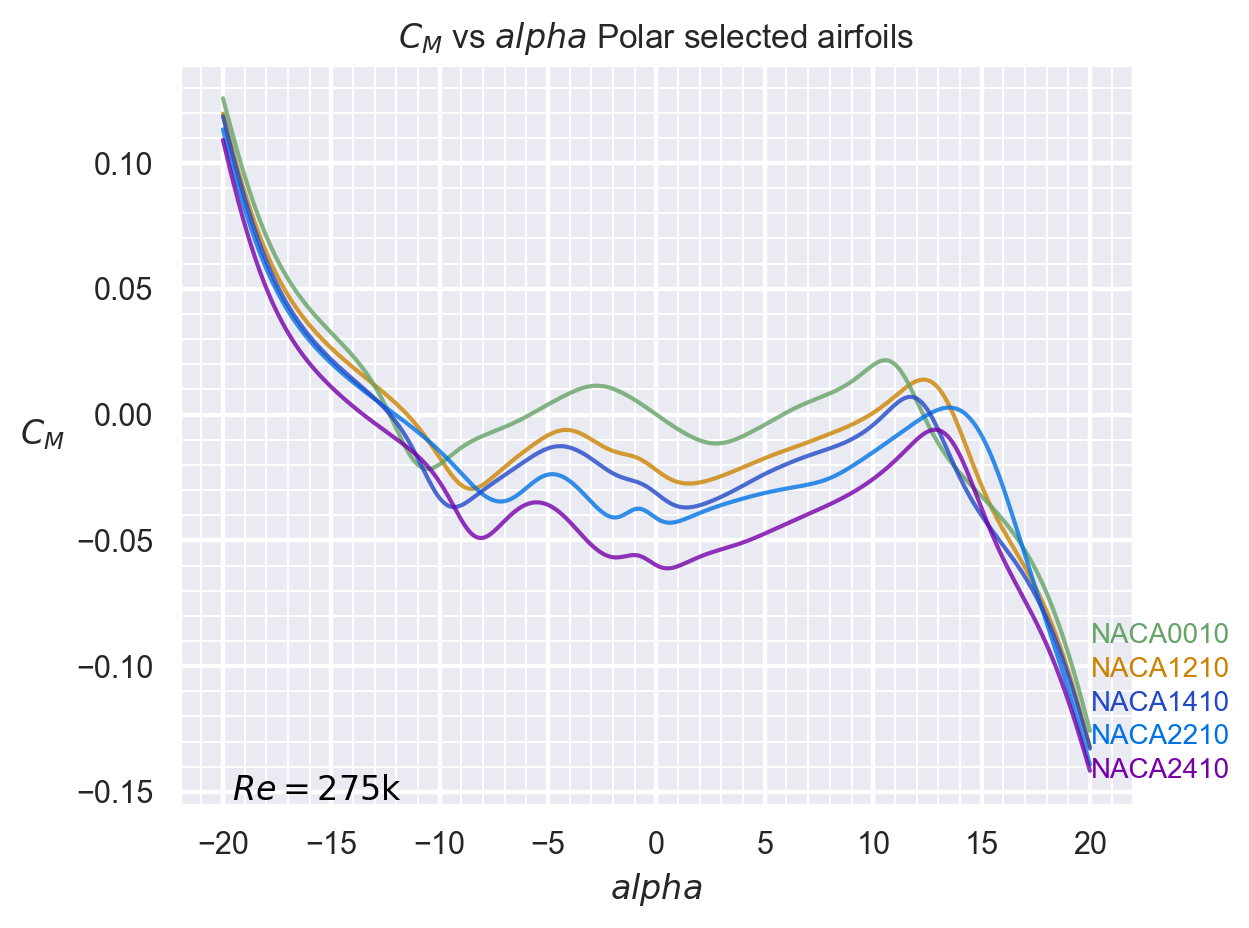

In [65]:
alphas = np.linspace(-20, 20, 401)  # degrees
re = 275e3 # Fixed Reynolds number at 10 deg c and 0.4 m chord 
Alpha, Re = np.meshgrid(alphas, re)

# How many airfoils to plot
N = 5

# To avoid overlapping labels
text_height_offset = 0.05
x_padding = 0.03

font_size = 10

# Define colors 
colors = LinearSegmentedColormap.from_list(
    "custom_cmap",
    colors=[
        p.adjust_lightness(c, 0.8) for c in
        ["orange", "darkseagreen", "dodgerblue", "royalblue", "darkviolet"]
    ]
)(np.linspace(0, 1, N))

# Compute aerodynamics for all airfoils
Aero_array = []
af_names = []
for result in sorted_results[:N]:
    af_name = naca_foils[min_drag.index(result)].upper()
    af_names.append(af_name)
    af = asb.Airfoil(af_name)

    aero_flattened = af.get_aero_from_neuralfoil(
        alpha=Alpha.flatten(),
        Re=Re.flatten(),
        mach=0,
        model_size="xxxlarge",
    )
    Aero = {
        key: value.reshape(Alpha.shape)
        for key, value in aero_flattened.items()
    }
    Aero_array.append(Aero)


##### Plot CD vs CL #####
fig, ax = plt.subplots()
y_endpoints = []
y_max = []
y_min = []
for i in range(len(Aero_array)):
    line, = ax.plot(
        Aero_array[i]["CD"][0],
        Aero_array[i]["CL"][0],
        color=colors[i], alpha=0.8,
    )
    y_max.append(np.max(line.get_ydata()))
    y_min.append(np.min(line.get_ydata()))
    y_endpoints.append(line.get_ydata()[-1])
y_max = np.max(y_max)
y_min = np.min(y_min)
sorted_endpoints, y_coordinates = spread_y_labels(y_endpoints, spacing=text_height_offset, ymin=y_min, ymax=y_max)
for i in range(len(Aero_array)):
    y_coord = y_coordinates[sorted_endpoints.index(y_endpoints[i])]
    plt.annotate(
        af_names[i],
        xy=(line.get_xdata()[-1] + x_padding, y_coord),
        color=colors[i],
        ha="left", va="center", fontsize=font_size
    )
    
plt.annotate(
    f" $Re = \\mathrm{{{eng_string(re)}}}$",
    xy=(0.13, -1),
    color="black",
    ha="left", va="center", fontsize=font_size + 2
)

plt.xscale('log')
p.show_plot(
    title=f"$C_L$-$C_D$ comparison for selected Airfoils",
    xlabel="$C_D$",
    ylabel="$C_L$",
)


##### Plot CL vs alpha #####
fig, ax = plt.subplots()
y_endpoints = []
y_max = []
y_min = []
for i in range(len(Aero_array)):
    line, = ax.plot(
        Alpha[0, :],
        Aero_array[i]["CL"][0],
        color=colors[i], alpha=0.8,
    )
    y_max.append(np.max(line.get_ydata()))
    y_min.append(np.min(line.get_ydata()))
    y_endpoints.append(line.get_ydata()[-1])
y_max = np.max(y_max)
y_min = np.min(y_min)
sorted_endpoints, y_coordinates = spread_y_labels(y_endpoints, spacing=text_height_offset, ymin=y_min, ymax=y_max)
for i in range(len(Aero_array)):
    y_coord = y_coordinates[sorted_endpoints.index(y_endpoints[i])]
    plt.annotate(
        af_names[i],
        xy=(line.get_xdata()[-1] + x_padding, y_coord),
        color=colors[i],
        ha="left", va="center", fontsize=font_size
    )
    
plt.annotate(
    f" $Re = \\mathrm{{{eng_string(re)}}}$",
    xy=(12.5, -1),
    color="black",
    ha="left", va="center", fontsize=font_size + 2
)

p.show_plot(
        title=f"$C_L$ vs $alpha$ Polar for selected airfoils",
        xlabel="$alpha$",
        ylabel="$C_L$",
    )


##### Plot CD vs alpha #####
fig, ax = plt.subplots()
y_endpoints = []
y_max = []
y_min = []
for i in range(len(Aero_array)):
    line, = ax.plot(
        Alpha[0, :],
        Aero_array[i]["CD"][0],
        color=colors[i], alpha=0.8,
    )
    y_max.append(np.max(line.get_ydata()))
    y_min.append(np.min(line.get_ydata()))
    y_endpoints.append(line.get_ydata()[-1])
y_max = np.max(y_max)
y_min = np.min(y_min)
sorted_endpoints, y_coordinates = spread_y_labels(y_endpoints, spacing=text_height_offset, ymin=y_min, ymax=y_max)
for i in range(len(Aero_array)):    
    y_coord = y_coordinates[sorted_endpoints.index(y_endpoints[i])]
    plt.annotate(
        af_names[i],
        xy=(line.get_xdata()[-1] + x_padding, y_coord),
        color=colors[i],
        ha="left", va="center", fontsize=font_size
    )
plt.annotate(
    f" $Re = \\mathrm{{{eng_string(re)}}}$",
    xy=(13, 0.01),
    color="black",
    ha="left", va="center", fontsize=font_size + 2
)

p.show_plot(
        title=f"$C_D$ vs $alpha$ Polar for {af.name} Airfoil",
        xlabel="$alpha$",
        ylabel="$C_D$",
    )


##### Plot CL/CD vs alpha #####
fig, ax = plt.subplots()
y_endpoints = []
y_max = []
y_min = []
for i in range(len(Aero_array)):
    line, = ax.plot(
        Alpha[0, :],
        Aero_array[i]["CL"][0]/Aero_array[i]["CD"][0],
        color=colors[i], alpha=0.8,
    )
    y_max.append(np.max(line.get_ydata()))
    y_min.append(np.min(line.get_ydata()))
    y_endpoints.append(line.get_ydata()[-1])
y_max = np.max(y_max)
y_min = np.min(y_min)
sorted_endpoints, y_coordinates = spread_y_labels(y_endpoints, spacing=text_height_offset, ymin=y_min, ymax=y_max)
for i in range(len(Aero_array)):    
    y_coord = y_coordinates[sorted_endpoints.index(y_endpoints[i])]
    plt.annotate(
        af_names[i],
        xy=(line.get_xdata()[-1] + x_padding, y_coord),
        color=colors[i],
        ha="left", va="center", fontsize=font_size
    )
plt.annotate(
    f" $Re = \\mathrm{{{eng_string(re)}}}$",
    xy=(13, -46),
    color="black",
    ha="left", va="center", fontsize=font_size + 2
)

p.show_plot(
        title=f"$C_L$/$C_D$ vs $alpha$ Polar for selected airfoils",
        xlabel="$alpha$",
        ylabel="$C_L$/$C_D$",
    )

##### Plot CM vs alpha #####
fig, ax = plt.subplots()
y_endpoints = []
y_max = []
y_min = []
for i in range(len(Aero_array)):
    line, = ax.plot(
        Alpha[0, :],
        Aero_array[i]["CM"][0],
        color=colors[i], alpha=0.8,
    )
    y_max.append(np.max(line.get_ydata()))
    y_min.append(np.min(line.get_ydata()))
    y_endpoints.append(line.get_ydata()[-1])
y_max = np.max(y_max)
y_min = np.min(y_min)
sorted_endpoints, y_coordinates = spread_y_labels(y_endpoints, spacing=text_height_offset, ymin=y_min, ymax=y_max)
for i in range(len(Aero_array)):    
    y_coord = y_coordinates[sorted_endpoints.index(y_endpoints[i])]
    plt.annotate(
        af_names[i],
        xy=(line.get_xdata()[-1] + x_padding, y_coord),
        color=colors[i],
        ha="left", va="center", fontsize=font_size
    )
plt.annotate(
    f" $Re = \\mathrm{{{eng_string(re)}}}$",
    xy=(-20, -0.15),
    color="black",
    ha="left", va="center", fontsize=font_size + 2
)

p.show_plot(
        title=f"$C_M$ vs $alpha$ Polar selected airfoils",
        xlabel="$alpha$",
        ylabel="$C_M$",
    )

    

### Stall characteristics plot

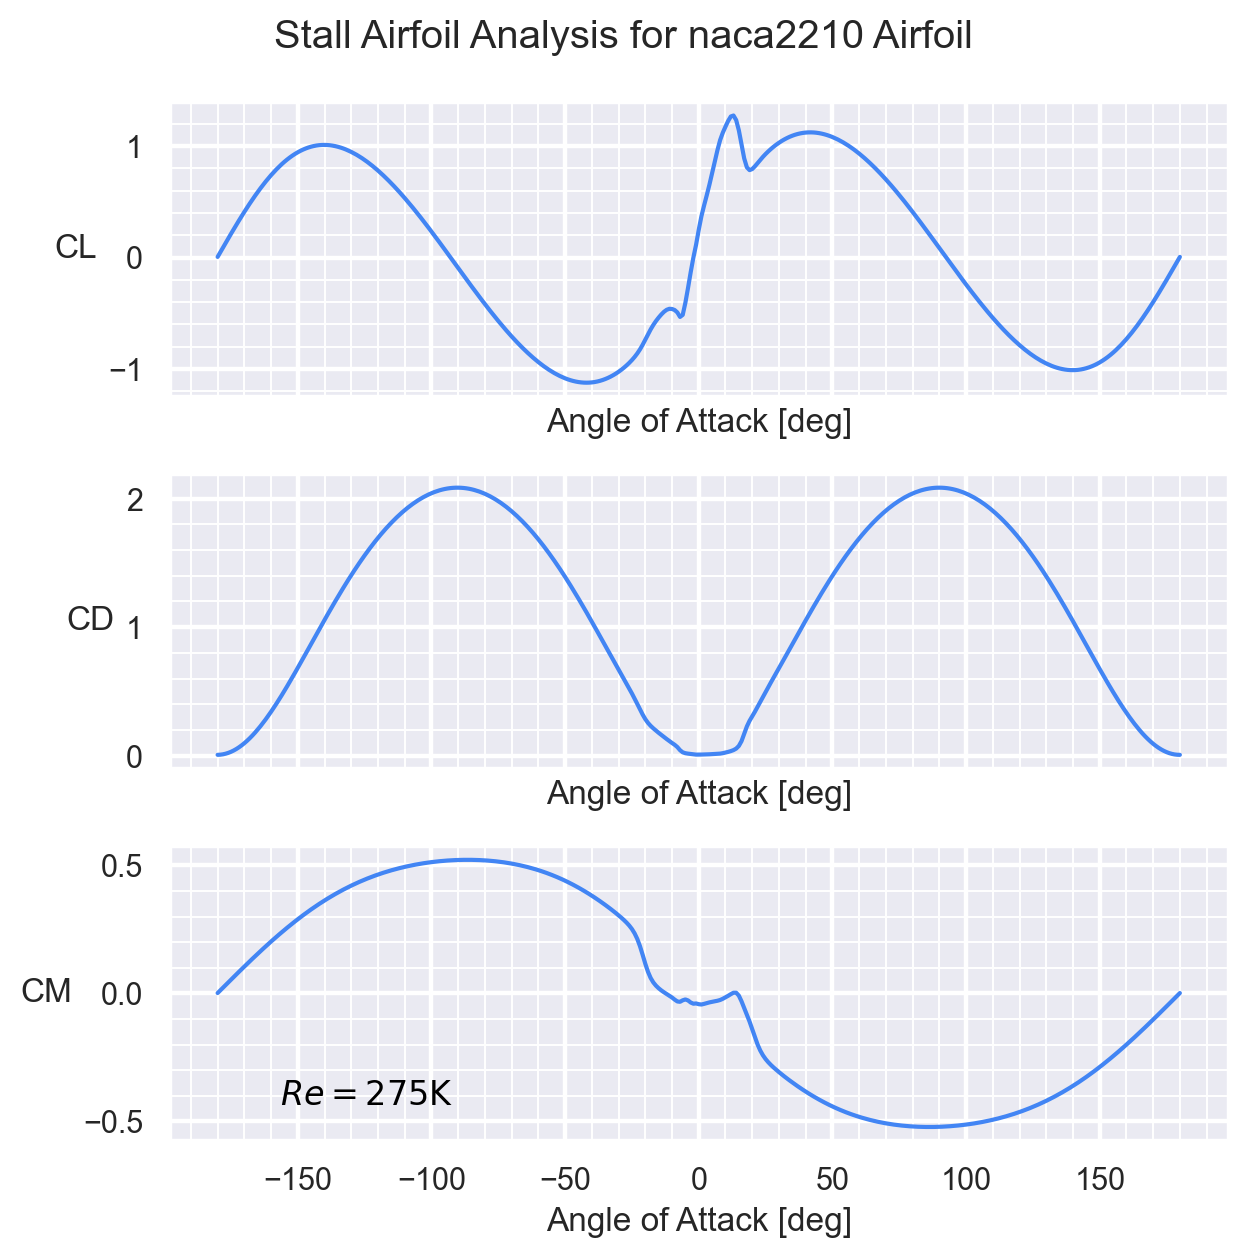

In [91]:
alpha = np.linspace(-180, 180, 361)
aero = af.get_aero_from_neuralfoil(
    alpha=alpha,
    Re=275e3,
    mach=0,
)

keys_to_plot = ["CL", "CD", "CM"]

fig, ax = plt.subplots(len(keys_to_plot), 1, figsize=(6.4, 6.4), sharex=True)
for i, key in enumerate(keys_to_plot):
    plt.sca(ax[i])
    plt.plot(
        alpha,
        aero[key],
    )
    plt.ylabel(key)
    if key == "CM":
        plt.annotate(
            f" $Re = \\mathrm{{{eng_string(275)}K}}$",
            xy=(-160, -0.4),
            color="black",
            ha="left", va="center", fontsize=12
        )
    p.set_ticks(45, 15)
    from matplotlib.ticker import AutoMinorLocator

    ax[i].yaxis.set_minor_locator(AutoMinorLocator())

p.show_plot(
    title=f"Stall Airfoil Analysis for {af.name} Airfoil",
    xlabel="Angle of Attack [deg]",
    set_ticks=True
)

### Plot simulated Cl against model 

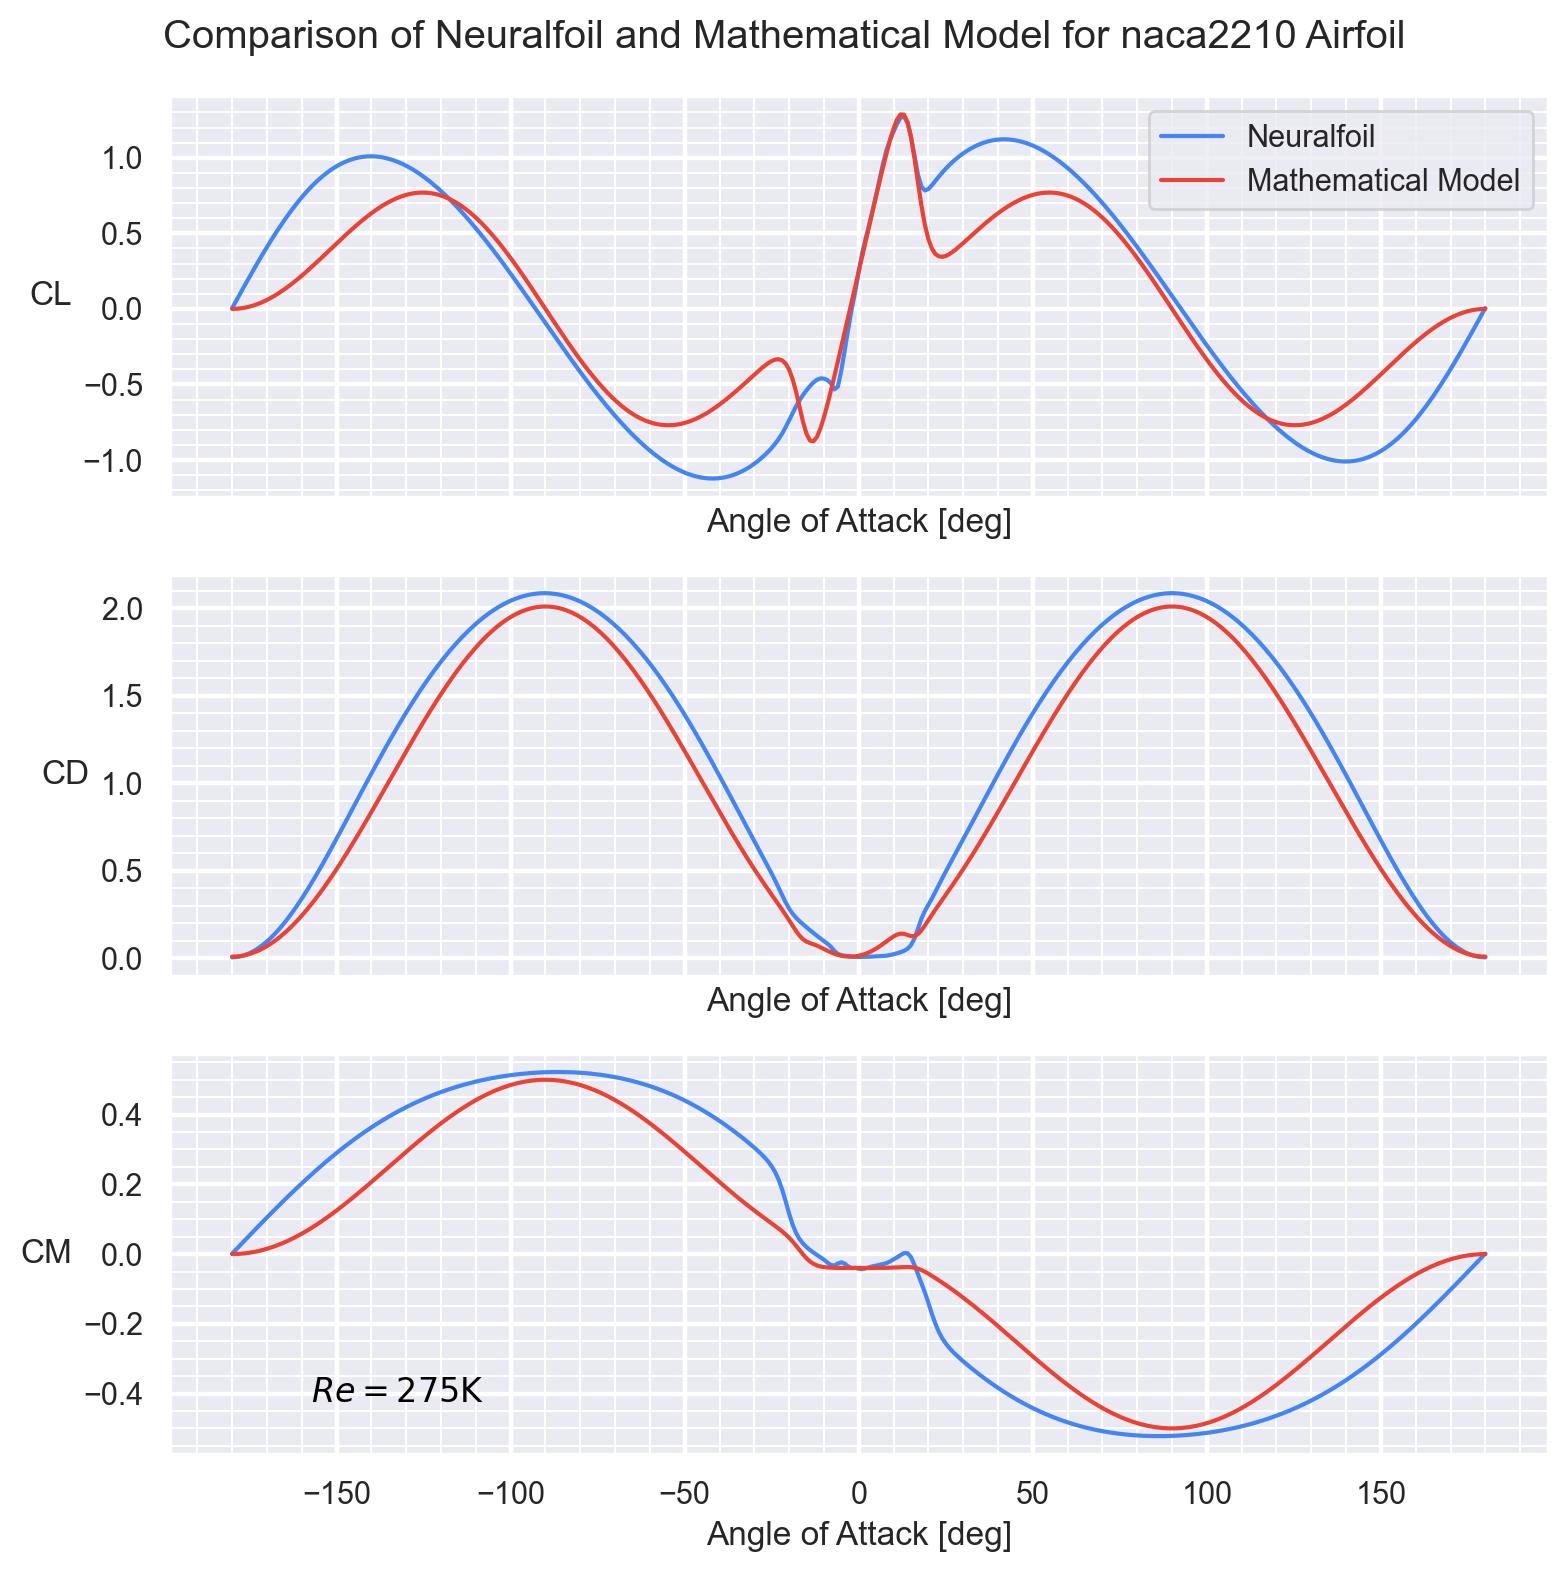

In [93]:
alpha = np.linspace(-180, 180, 361)

# Model for coefficient of lift
def flat_plate_cl(alpha):
    return 2*np.sign(alpha)*np.sin(np.deg2rad(alpha))**2*np.cos(np.deg2rad(alpha))

def sigmoid(alpha, alpha_stall, M):
    return (1 + np.exp(-M * (alpha - alpha_stall)) + 1 + np.exp(M * (alpha + alpha_stall))) / ((1 + np.exp(-M * (alpha - alpha_stall)))*(1 + np.exp(M * (alpha + alpha_stall))))

def cl_model(alpha, alpha_stall, cl_alpha, zero_alpha_lift, M):
    return (1 - sigmoid(alpha, alpha_stall, M))*(zero_alpha_lift + cl_alpha*alpha) + sigmoid(alpha, alpha_stall, M)*flat_plate_cl(alpha)


# model parameters for cl
alpha_stall = 16
zero_alpha_lift = 0.25
cl_alpha = 0.1
M = 0.5

cl_mod = cl_model(alpha, alpha_stall, cl_alpha, zero_alpha_lift, M)

# model for coefficient of drag
def small_alpha_cd(alpha, alpha_stall, cl_alpha, zero_alpha_lift, M, aspect_ratio, oswald_eff): # lift induced drag
    return (cl_model(alpha, alpha_stall, cl_alpha, zero_alpha_lift, M)**2)/(np.pi*aspect_ratio*oswald_eff)

def flat_plate_cd(alpha, cd_scale):
    return cd_scale*np.sin(np.deg2rad(alpha))**2

def cd_model(alpha, aspect_ratio, oswald_eff, cd_parasitic, alpha_stall, cl_alpha, M, zero_alpha_lift, cd_scale):
    return cd_parasitic + (1 - sigmoid(alpha, alpha_stall, M))*(small_alpha_cd(alpha, alpha_stall, cl_alpha, zero_alpha_lift, M, aspect_ratio, oswald_eff)) + sigmoid(alpha, alpha_stall, M)*flat_plate_cd(alpha, cd_scale)


# model parameters for cd
oswald_eff = 0.8
cd_parasitic = 0.01
aspect_ratio = MAX_SPAN/MIN_CHORD
cd_scale = 2

cd_mod = cd_model(alpha, aspect_ratio, oswald_eff, cd_parasitic, alpha_stall, cl_alpha, M, zero_alpha_lift, cd_scale)

# model for coefficient of moment
def flat_plate_cm(alpha, cm_scale):
    return -1*cm_scale*np.sign(alpha)*np.sin(np.deg2rad(alpha))**2

def cm_model(alpha, alpha_stall, zero_alpha_moment, M, cm_scale):
    return (1 - sigmoid(alpha, alpha_stall, M))*(zero_alpha_moment) + sigmoid(alpha, alpha_stall, M)*flat_plate_cm(alpha, cm_scale)

# model parameters for cm
zero_alpha_moment = -0.04
cm_scale =0.5
cm_mod = cm_model(alpha, alpha_stall, zero_alpha_moment, M, cm_scale)

# Adrians mathematical model
aero_mod = {
    "CL": cl_mod,
    "CD": cd_mod,
    "CM": cm_mod
}

# Neuralfoil model

af = asb.Airfoil("naca2210")

aero = af.get_aero_from_neuralfoil(
    alpha=alpha,
    Re=275e3,
    mach=0,
)
colors = LinearSegmentedColormap.from_list(
    "custom_cmap",
    colors=[
        p.adjust_lightness(c, 0.8) for c in
        ["orange", "darkseagreen", "dodgerblue"]
    ]
)(np.linspace(0, 1, 2))

keys_to_plot = ["CL" , "CD", "CM"]

fig, ax = plt.subplots(len(keys_to_plot), 1, figsize=(8, 8), sharex=True)
for i, key in enumerate(keys_to_plot):
    plt.sca(ax[i])
    plt.plot(
        alpha,
        aero[key],
    )
    plt.plot(
        alpha,
        aero_mod[key],
    )
    plt.ylabel(key)
    if key == "CL":
        plt.legend(["Neuralfoil", "Mathematical Model"], loc="upper right")
    if key == "CM":
        plt.annotate(
            f" $Re = \\mathrm{{{eng_string(275)}K}}$",
            xy=(-160, -0.4),
            color="black",
            ha="left", va="center", fontsize=12
        )
    p.set_ticks(45, 15)
    from matplotlib.ticker import AutoMinorLocator

    ax[i].yaxis.set_minor_locator(AutoMinorLocator())

p.show_plot(
    title=f"Comparison of Neuralfoil and Mathematical Model for {af.name} Airfoil",
    xlabel="Angle of Attack [deg]",
    set_ticks=True
)

### Maximum acheivable L/D for airfoil
Only really relevant for higher Mach numbers

C:\Users\adria\AppData\Local\Temp\ipykernel_24208\4086510414.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("RdBu")


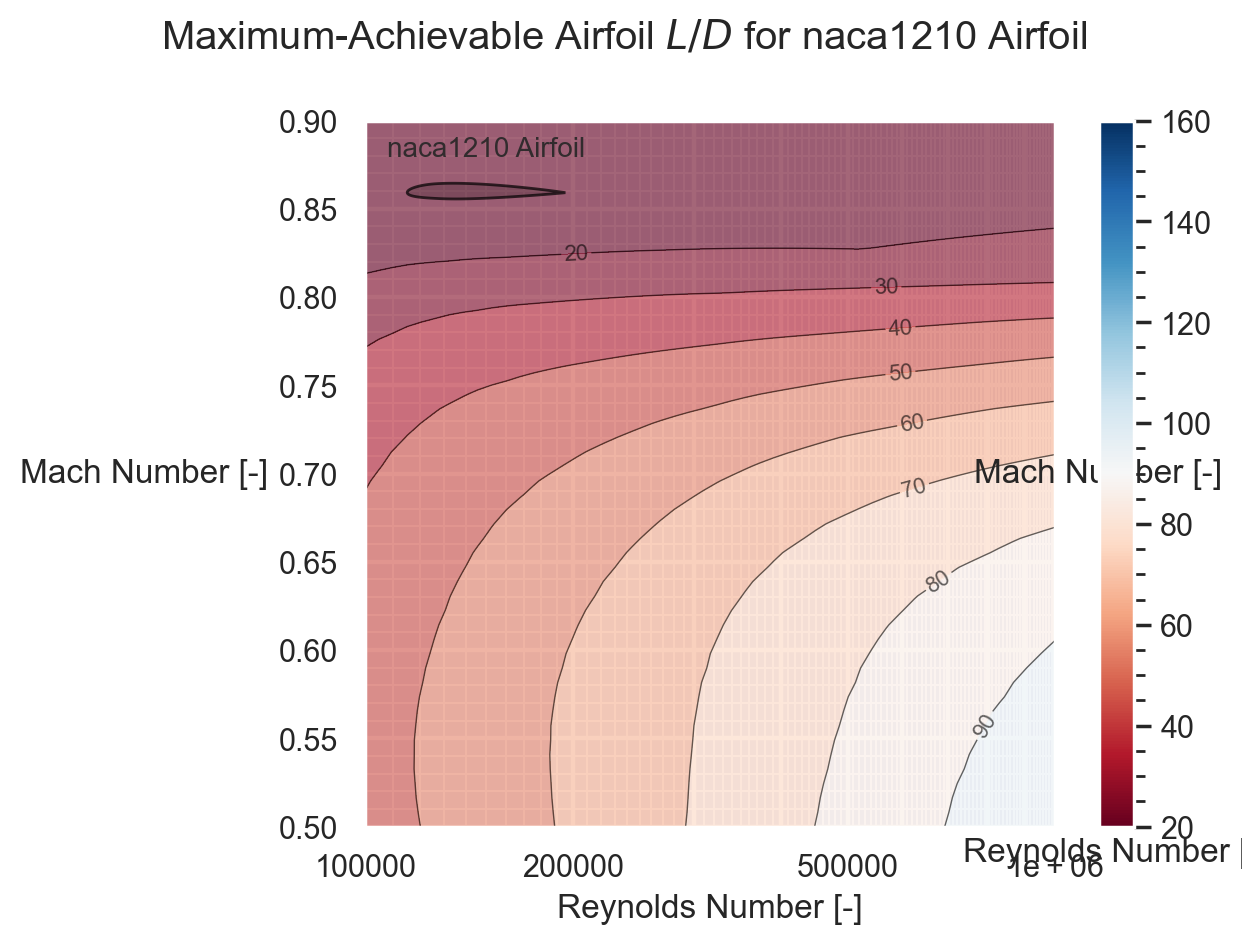

In [40]:
re = np.geomspace(1e5, 1e6, 50)
mach = np.linspace(0.5, 0.9, 50)
alpha = np.linspace(-3, 7, 50)

Re, Mach, Alpha = np.meshgrid(re, mach, alpha)

aero_f = af.get_aero_from_neuralfoil(
    alpha=Alpha.flatten(),
    Re=Re.flatten(),
    mach=Mach.flatten(),
)
aero = {
    k: np.reshape(v, Re.shape) for k, v in aero_f.items()
}

cmap = plt.cm.get_cmap("RdBu")

fig, ax = plt.subplots()


LD = np.max(aero["CL"] / aero["CD"], axis=-1)

p.contour(
    re, mach, LD,
    levels=np.arange(0, 400, 10),
    x_log_scale=True,
    cmap=cmap, alpha=0.6,
    colorbar_label="Max-Achievable Airfoil $L/D$ across all $\\alpha$",
)
plt.clim(20, 160)
plt.xscale('log')

afax = ax.inset_axes([0.05, 0.8, 0.25, 0.20])
afax.fill(
    af.x(), af.y(),
    facecolor=(0, 0, 0, 0.2), linewidth=1, edgecolor=(0, 0, 0, 0.7)
)
afax.annotate(
    text=f"{af.name} Airfoil\n",
    xy=(0.5, 0),
    ha="center", va="bottom", fontsize=10,
    alpha=0.9
)
afax.axis('off')
afax.axis('equal')

p.show_plot(
    title=f"Maximum-Achievable Airfoil $L/D$ for {af.name} Airfoil",
    xlabel="Reynolds Number [-]",
    ylabel="Mach Number [-]",
)